In [170]:
#importing neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn import preprocessing
from sklearn.ensemble import *
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [171]:
train=pd.read_csv('train_users_2.csv')
test=pd.read_csv('test_users.csv')


In [172]:
print('The training data contains', train.shape[1], 'columns and', train.shape[0], ' rows.   While the test data contains',  test.shape[0], 'columns and', test.shape[1], '.')

The training data contains 16 columns and 213451  rows.   While the test data contains 62096 columns and 15 .


In [173]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [174]:
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [175]:
for i in train.columns:
  if train[i].isna().sum() !=0:
    print('The columns "', i, '" has', train[i].isna().sum(), 'null values.' )

The columns " date_first_booking " has 124543 null values.
The columns " age " has 87990 null values.
The columns " first_affiliate_tracked " has 6065 null values.


In [176]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

(None, None)

In [177]:
#drop columns with so many null values
train = train.drop(['date_first_booking'], axis = 1)
test= test.drop(['date_first_booking'], axis=1)


In [178]:
#let's drop these columns because according to the features importance they should not be in there
'''train = train.drop(['signup_app','first_browser','signup_flow'], axis = 1)
test = test.drop(['signup_app','first_browser','signup_flow'], axis = 1)'''


"train = train.drop(['signup_app','first_browser','signup_flow'], axis = 1)\ntest = test.drop(['signup_app','first_browser','signup_flow'], axis = 1)"

In [179]:
#Converting below columns as categories for plotting in graphs
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
   'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
  #  'signup_flow'
]

for categorical_feature in categorical_features:
    train[categorical_feature] = train[categorical_feature].astype('category')
    test[categorical_feature] = test[categorical_feature].astype('category')

In [180]:
train['date_account_created'] = pd.to_datetime(train['date_account_created'])

test['date_account_created'] = pd.to_datetime(test['date_account_created'])


In [181]:
# timestamp_first_active transformation
# Here as well we separate the timestamp first active into day mount and year
#train.timestamp_first_active = train.timestamp_first_active.apply(lambda x: x.timestamp())

tfa = np.vstack(train.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)

print(tfa)
train['tfa_year'] = tfa[:,0]
train['tfa_month'] = tfa[:,1]
train['tfa_day'] = tfa[:,2]


train['timestamp_first_active']=pd.to_datetime(train['timestamp_first_active'],format='%Y%m%d%H%M%S')
from datetime import datetime
k=[]
for i in train['timestamp_first_active']:
  k.append(i.strftime('%A'))

train['tfa_day']=k

#train = train.drop(['timestamp_first_active'], axis=1)



[[2009    3   19    4   32   55]
 [2009    5   23   17   48    9]
 [2009    6    9   23   12   47]
 ...
 [2014    6   30   23   57   54]
 [2014    6   30   23   58   22]
 [2014    6   30   23   58   24]]


**AGE**

In [182]:
train.age.describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [183]:
(train.age > 100).value_counts()


False    211106
True       2345
Name: age, dtype: int64

In [184]:
(train.age < 18).value_counts()


False    213293
True        158
Name: age, dtype: int64

In [185]:
train[(train['age']<18) & (train['age']>=100)].age = np.nan
test[(train['age']<18) & (test['age']>=100)].age = np.nan


In [186]:
train.shape[0]-train.age.isna().sum()

125461

In [187]:
#let's fill the null values with the median 

train['age']= train['age'].fillna(train['age'].median())
test['age']= test['age'].fillna(train['age'].median())

**GENDER**

In [188]:
print('for train data: ', train.gender.value_counts())
print('-----------------------------')
print('for test data: ', test.gender.value_counts())


for train data:  -unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64
-----------------------------
for test data:  -unknown-    33792
FEMALE       14483
MALE         13769
OTHER           52
Name: gender, dtype: int64


In [189]:
train = train[train.country_destination != 'NDF']


In [190]:
train.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,tfa_year,tfa_month,tfa_day
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009,6,Tuesday
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009,10,Saturday
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009,12,Tuesday
5,osr2jwljor,2010-01-01,2010-01-01 21:56:19,-unknown-,34.0,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,2010,1,Friday
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010,1,Saturday


**DATES**

In [191]:
# Date_account_created transformation
# Separate the day month and year into different columns
dac = np.vstack(train.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
print(dac)
train['dac_year'] = dac[:,0]
train['dac_mounth'] = dac[:,1]
train['dac_day'] = dac[:,2]

train['date_account_created']=pd.to_datetime(train['date_account_created'])
from datetime import datetime
l=[]
for i in train['date_account_created']:
  l.append(i.strftime('%A'))

train['dac_day']=l
train = train.drop(['date_account_created'], axis = 1)





[[2010    9   28]
 [2011   12    5]
 [2010    9   14]
 ...
 [2014    6   30]
 [2014    6   30]
 [2014    6   30]]


In [192]:
train.head()

,id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,tfa_year,tfa_month,tfa_day,dac_year,dac_mounth,dac_day
2,4ft3gnwmtx,2009-06-09 23:12:47,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009,6,Tuesday,2010,9,Tuesday
3,bjjt8pjhuk,2009-10-31 06:01:29,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009,10,Saturday,2011,12,Monday
4,87mebub9p4,2009-12-08 06:11:05,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009,12,Tuesday,2010,9,Tuesday
5,osr2jwljor,2010-01-01 21:56:19,-unknown-,34.0,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,2010,1,Friday,2010,1,Friday
6,lsw9q7uk0j,2010-01-02 01:25:58,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010,1,Saturday,2010,1,Saturday


In [193]:
print(train.isna().sum())
print('---------------------------------------------------')
print(test.isna().sum())


id                            0
timestamp_first_active        0
gender                        0
age                           0
signup_method                 0
signup_flow                   0
language                      0
affiliate_channel             0
affiliate_provider            0
first_affiliate_tracked    1738
signup_app                    0
first_device_type             0
first_browser                 0
country_destination           0
tfa_year                      0
tfa_month                     0
tfa_day                       0
dac_year                      0
dac_mounth                    0
dac_day                       0
dtype: int64
---------------------------------------------------
id                          0
date_account_created        0
timestamp_first_active      0
gender                      0
age                         0
signup_method               0
signup_flow                 0
language                    0
affiliate_channel           0
affiliate_provider       

In [194]:
train = train.drop(['timestamp_first_active'], axis=1)


In [195]:
train['first_affiliate_tracked'] = train['first_affiliate_tracked'].fillna(train['first_affiliate_tracked'].mode()[0])
test['first_affiliate_tracked'] = test['first_affiliate_tracked'].fillna(test['first_affiliate_tracked'].mode()[0])



In [196]:
# Date_account_created transformation
# Separate the day month and year into different columns
dac = np.vstack(test.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
print(dac)
test['dac_year'] = dac[:,0]
test['dac_mounth'] = dac[:,1]
test['dac_day'] = dac[:,2]

test['date_account_created']=pd.to_datetime(test['date_account_created'])
from datetime import datetime
l=[]
for i in test['date_account_created']:
  l.append(i.strftime('%A'))

test['dac_day']=l
test = test.drop(['date_account_created'], axis = 1)

[[2014    7    1]
 [2014    7    1]
 [2014    7    1]
 ...
 [2014    9   30]
 [2014    9   30]
 [2014    9   30]]


In [197]:
# timestamp_first_active transformation
# Here as well we separate the timestamp first active into day mount and year
tfa = np.vstack(test.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
print(tfa)
test['tfa_year'] = tfa[:,0]
test['tfa_month'] = tfa[:,1]
test['tfa_day'] = tfa[:,2]


test['timestamp_first_active']=pd.to_datetime(test['timestamp_first_active'],format='%Y%m%d%H%M%S')
from datetime import datetime
k=[]
for i in test['timestamp_first_active']:
  k.append(i.strftime('%A'))

test['tfa_day']=k
test = test.drop(['timestamp_first_active'], axis = 1)

[[2014    7    1    0    0    6]
 [2014    7    1    0    0   51]
 [2014    7    1    0    1   48]
 ...
 [2014    9   30   23   54    8]
 [2014    9   30   23   54   30]
 [2014    9   30   23   59    1]]


In [198]:
print(train.info())
print('---------------------------------------------------')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88908 entries, 2 to 213445
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       88908 non-null  object  
 1   gender                   88908 non-null  category
 2   age                      88908 non-null  float64 
 3   signup_method            88908 non-null  category
 4   signup_flow              88908 non-null  int64   
 5   language                 88908 non-null  category
 6   affiliate_channel        88908 non-null  category
 7   affiliate_provider       88908 non-null  category
 8   first_affiliate_tracked  88908 non-null  category
 9   signup_app               88908 non-null  category
 10  first_device_type        88908 non-null  category
 11  first_browser            88908 non-null  category
 12  country_destination      88908 non-null  object  
 13  tfa_year                 88908 non-null  int64   
 14  tfa_m

In [199]:
categorical_features=['dac_day', 'tfa_day','id']

for i in categorical_features:
    train[i] = train[i].astype('category')

for i in categorical_features:
    test[i] = test[i].astype('category')


train['age'] = train['age'].astype(np.int64)

In [200]:
print(train['gender'].value_counts())
print('------------------------------')
print(test['gender'].value_counts())




FEMALE       31993
-unknown-    29018
MALE         27721
OTHER          176
Name: gender, dtype: int64
------------------------------
-unknown-    33792
FEMALE       14483
MALE         13769
OTHER           52
Name: gender, dtype: int64


In [201]:
train['gender']=train['gender'].replace('-unknown-' , np.nan)
test['gender']=test['gender'].replace('-unknown-' , np.nan)


In [202]:
print('Number of missing values in the train data: ', train.gender.isna().sum())
print('---------------------------------------------------')
print('Number of missing values in the train data: ', test.gender.isna().sum())


Number of missing values in the train data:  29018
---------------------------------------------------
Number of missing values in the train data:  33792


In [203]:
train=train.dropna(subset=['gender'])
test=test.dropna(subset=['gender'])



In [204]:
from sklearn.preprocessing import *
encode=LabelEncoder()

signup_method_enc=train.signup_method
train.signup_method=encode.fit_transform(signup_method_enc)

affiliate_channel_enc=train.affiliate_channel
train.affiliate_channel=encode.fit_transform(affiliate_channel_enc)

affiliate_provider_enc=train.affiliate_provider
train.affiliate_provider=encode.fit_transform(affiliate_provider_enc)

#signup_app_enc=train.signup_app
#train.signup_app=encode.fit_transform(signup_app_enc)

signup_app_enc=train.signup_app
train.signup_app=encode.fit_transform(signup_app_enc)


first_device_type_enc=train.first_device_type
train.first_device_type=encode.fit_transform(first_device_type_enc)

#first_browser_enc=train.first_browser
#train.first_browser=encode.fit_transform(first_browser_enc)

first_browser_enc=train.first_browser
train.first_browser=encode.fit_transform(first_browser_enc)

gender_enc=train.gender
train.gender=encode.fit_transform(gender_enc)

first_affiliate_tracked_enc=train.first_affiliate_tracked
train.first_affiliate_tracked=encode.fit_transform(first_affiliate_tracked_enc)

language_enc=train.language
train.language=encode.fit_transform(language_enc)

dac_day_enc=train.language
train.dac_day=encode.fit_transform(dac_day_enc)

tfa_day_enc=train.language
train.tfa_day=encode.fit_transform(tfa_day_enc)



In [205]:
#xgboost needs to get the columns in the same order
train = train.reindex(sorted(train.columns), axis = 1)
test = train.reindex(sorted(test.columns), axis = 1)


In [206]:
# Dividing data into X and y
X = train.drop(['country_destination', 'id'], axis = 1)
y = train['country_destination']


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y) #Transforming the target variable using labels
encoded_y

array([ 9, 10,  9, ...,  3,  9,  9])

In [207]:
train.shape

(59890, 19)

In [208]:
#Standardizing the age column:
from sklearn.preprocessing import StandardScaler

st_cols= X[['age']]
st_cols= pd.DataFrame(StandardScaler().fit_transform(st_cols), columns=['age'] )

X['age'] = st_cols.values
X['age']

2         0.055421
3        -0.038382
6        -0.011581
7        -0.004881
8         0.015219
            ...   
213412    0.015219
213439   -0.031682
213441   -0.091983
213443   -0.078583
213445   -0.165685
Name: age, Length: 59890, dtype: float64

In [209]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.25, random_state=42)

In [210]:
# Using xgboost classifier
from xgboost import XGBClassifier, plot_importance
xgb = XGBClassifier(use_label_encoder=False)                  
xgb.fit(X_train, y_train)
#xgb.fit(train_x, y_train)


print('Model trained Successfully')

Model trained Successfully


In [211]:
y_pred = xgb.predict(X_test)
y_pred

array([9, 9, 9, ..., 9, 9, 9])

In [212]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
          101,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          241,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          205,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          363,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          840,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          385,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          447,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          127,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
           44,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
        10632,     0],
       [    0,     0,     0,     0,     0,     0,     0,    

In [213]:
from sklearn.metrics import classification_report

print("classification report of xgb:\n ",classification_report(y_test,y_pred))


classification report of xgb:
                precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00       241
           2       0.00      0.00      0.00       205
           3       0.00      0.00      0.00       363
           4       0.00      0.00      0.00       840
           5       0.00      0.00      0.00       385
           6       0.00      0.00      0.00       447
           7       0.00      0.00      0.00       127
           8       0.00      0.00      0.00        44
           9       0.71      1.00      0.83     10632
          10       0.00      0.00      0.00      1588

    accuracy                           0.71     14973
   macro avg       0.06      0.09      0.08     14973
weighted avg       0.50      0.71      0.59     14973



In [214]:
from sklearn.metrics import precision_score
print('Accuracy of xgb:' , accuracy_score(y_test, y_pred))
print("precision of xgb",precision_score(y_test, y_pred,average='weighted'))

Accuracy of xgb: 0.7100781406531758
precision of xgb 0.5042109658334712


<Figure size 3600x6480 with 0 Axes>

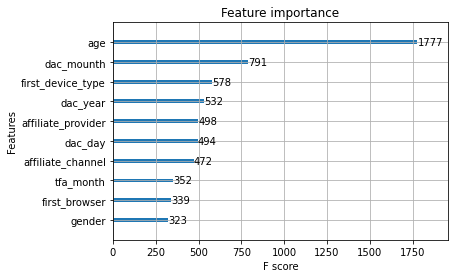

In [215]:
plt.figure(figsize=(50,90))

plot_importance(xgb, max_num_features=10)
f_importances= xgb.feature_importances_

In [216]:
# Change parameters of xgboost
from xgboost import XGBClassifier, plot_importance
xgb2 = XGBClassifier(use_label_encoder=True,max_depth=4, learning_rate=0.2, n_estimators=50,
                    objective='multi:softmax' #subsample=0.6, colsample_bytree=0.6, silent=0
                     )                  
xgb2.fit(X_train, y_train)

print('xgb2 trained Successfully')

xgb2 trained Successfully


In [217]:
y_pred2 = xgb2.predict(X_test)

In [218]:
print('Accuracy of xgb2:', accuracy_score(y_test, y_pred2))
print('Precision of xgb2: ', precision_score(y_test, y_pred,average='weighted'))

Accuracy of xgb2: 0.7099445668870634
Precision of xgb2:  0.5042109658334712


In [219]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred2)

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
          101,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          241,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          205,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          363,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          840,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          385,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          447,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
          127,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
           44,     0],
       [    0,     0,     0,     0,     1,     0,     0,     0,     0,
        10630,     1],
       [    0,     0,     0,     0,     0,     0,     0,    

In [220]:
from sklearn.metrics import classification_report

print("classification report of xgb2: ", classification_report(y_test,y_pred2))


classification report of xgb2:                precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00       241
           2       0.00      0.00      0.00       205
           3       0.00      0.00      0.00       363
           4       0.00      0.00      0.00       840
           5       0.00      0.00      0.00       385
           6       0.00      0.00      0.00       447
           7       0.00      0.00      0.00       127
           8       0.00      0.00      0.00        44
           9       0.71      1.00      0.83     10632
          10       0.00      0.00      0.00      1588

    accuracy                           0.71     14973
   macro avg       0.06      0.09      0.08     14973
weighted avg       0.50      0.71      0.59     14973



<Figure size 3600x6480 with 0 Axes>

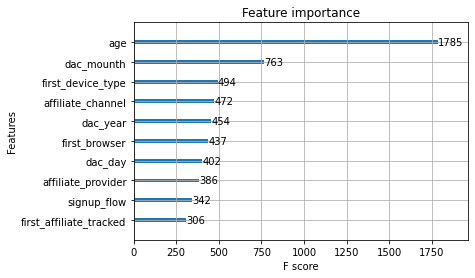

In [221]:
plt.figure(figsize=(50,90))

plot_importance(xgb2, max_num_features=10)
f_importances= xgb2.feature_importances_

In [222]:
# Change parameters of xgboost
from xgboost import XGBClassifier, plot_importance
xgb3 = XGBClassifier(max_depth=3, Min_Child_weight=5, learning_rate=0.2, n_estimators=50,
                    objective='multi:softmax', subsample=0.2, colsample_bytree=0.2, silent=0
                     )                  
xgb3.fit(X_train, y_train)

print('xgb3 trained Successfully')

xgb3 trained Successfully


In [223]:
y_pred8 = xgb3.predict(X_test)

In [224]:
from sklearn.metrics import classification_report

print("classification report of xgb3: ", classification_report(y_test,y_pred8))


classification report of xgb3:                precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00       241
           2       0.00      0.00      0.00       205
           3       0.00      0.00      0.00       363
           4       0.00      0.00      0.00       840
           5       0.00      0.00      0.00       385
           6       0.00      0.00      0.00       447
           7       0.00      0.00      0.00       127
           8       0.00      0.00      0.00        44
           9       0.71      1.00      0.83     10632
          10       0.00      0.00      0.00      1588

    accuracy                           0.71     14973
   macro avg       0.06      0.09      0.08     14973
weighted avg       0.50      0.71      0.59     14973



In [225]:
#using Adaboost
Adaboost= AdaBoostClassifier(random_state=96)

Adaboost.fit(X_train, y_train)

print("adaboost Trained succesfully!")

adaboost Trained succesfully!


In [226]:
y_pred3=Adaboost.predict(X_test)
y_pred3

array([9, 9, 9, ..., 9, 9, 9])

In [227]:
print('Accuracy of adaboost: ', accuracy_score(y_test, y_pred3))
print('Precision of Adaboost: ', precision_score(y_test, y_pred3,average='weighted'))

Accuracy of adaboost:  0.7017965671542109
Precision of Adaboost:  0.5039511753332142


In [228]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix of rfc:\n",confusion_matrix(y_test, y_pred3))

Confusion matrix of rfc:
 [[    0     0     0     0     0     0     0     0     0   101     0]
 [    0     0     0     0     0     0     0     0     3   238     0]
 [    0     0     0     0     0     0     0     0     2   203     0]
 [    0     0     0     0     0     0     0     0     3   360     0]
 [    0     0     0     0     0     0     0     0     7   833     0]
 [    0     0     0     0     0     0     0     0     1   384     0]
 [    0     0     0     0     0     0     0     0     5   442     0]
 [    0     0     0     0     0     0     0     0     0   127     0]
 [    0     0     0     0     0     0     0     0     0    44     0]
 [    0     0     0     0     0     0     0     0   124 10508     0]
 [    0     0     0     0     0     0     0     0    22  1566     0]]


In [229]:
from sklearn.metrics import classification_report

print("Classification report od Adaboost: \n",classification_report(y_test,y_pred3))


Classification report od Adaboost: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00       241
           2       0.00      0.00      0.00       205
           3       0.00      0.00      0.00       363
           4       0.00      0.00      0.00       840
           5       0.00      0.00      0.00       385
           6       0.00      0.00      0.00       447
           7       0.00      0.00      0.00       127
           8       0.00      0.00      0.00        44
           9       0.71      0.99      0.83     10632
          10       0.00      0.00      0.00      1588

    accuracy                           0.70     14973
   macro avg       0.06      0.09      0.08     14973
weighted avg       0.50      0.70      0.59     14973



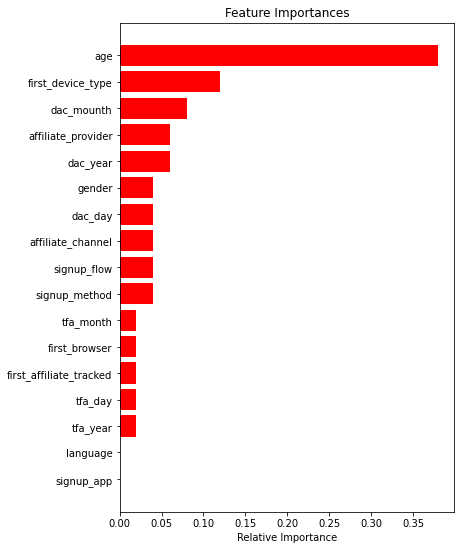

In [230]:

features = X_train.columns
importances = Adaboost.feature_importances_

indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(6,9))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')

plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [231]:
#using random forest
from sklearn.ensemble import RandomForestClassifier

rfc= RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)

print("rfc Trained succesfully!")


rfc Trained succesfully!


In [232]:
y_pred4=rfc.predict(X_test)
y_pred4

array([9, 9, 9, ..., 9, 1, 9])

In [233]:
print('Accuracy of rfc:',  accuracy_score(y_test, y_pred4))
print('Precision of rfc: ', precision_score(y_test, y_pred4,average='weighted'))

Accuracy of rfc: 0.6423562412342216
Precision of rfc:  0.5244847302367083


In [234]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix of rfc: \n",confusion_matrix(y_test, y_pred4))

Confusion matrix of rfc: 
 [[   1    0    0    2    3    1    1    0    0   91    2]
 [   1    0    1    1    6    1    2    0    1  220    8]
 [   0    0    3    0    7    3    5    0    0  178    9]
 [   1    1    0    3    9    6    3    2    0  326   12]
 [   5    5    6   11   15    5    6    1    1  743   42]
 [   1    3    2    1    9    7    5    1    0  337   19]
 [   2    6    3    3    7    3    7    2    1  393   20]
 [   0    0    0    0    3    0    1    2    0  116    5]
 [   1    0    0    0    1    1    1    0    0   38    2]
 [  32   50   34   86  207   88   98   27    9 9503  498]
 [   8    7    3   14   23   12   19    9    1 1415   77]]


In [235]:
from sklearn.metrics import classification_report

print("classification report of rfc: \n", classification_report(y_test,y_pred4))


classification report of rfc: 
               precision    recall  f1-score   support

           0       0.02      0.01      0.01       101
           1       0.00      0.00      0.00       241
           2       0.06      0.01      0.02       205
           3       0.02      0.01      0.01       363
           4       0.05      0.02      0.03       840
           5       0.06      0.02      0.03       385
           6       0.05      0.02      0.02       447
           7       0.05      0.02      0.02       127
           8       0.00      0.00      0.00        44
           9       0.71      0.89      0.79     10632
          10       0.11      0.05      0.07      1588

    accuracy                           0.64     14973
   macro avg       0.10      0.09      0.09     14973
weighted avg       0.52      0.64      0.57     14973



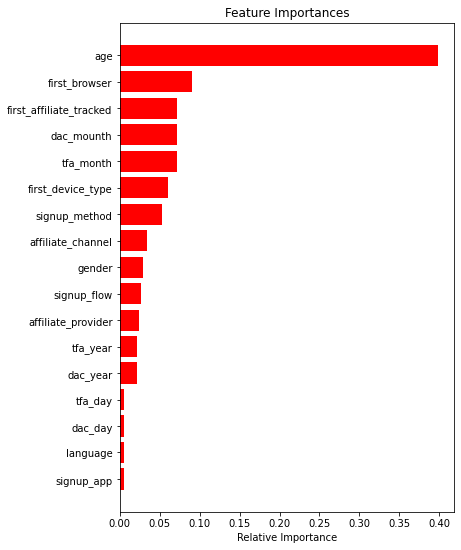

In [236]:

features = X_train.columns
importances = rfc.feature_importances_

indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(6,9))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')

plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [237]:
#using KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)
  
knn.fit(X_train, y_train)
  


KNeighborsClassifier(n_neighbors=9)

In [238]:
y_pred5=knn.predict(X_test)
y_pred5

array([9, 9, 9, ..., 9, 9, 9])

In [239]:
print('Accuracy of knn:',  accuracy_score(y_test, y_pred5))
print('Precision of knn: ', precision_score(y_test, y_pred5,average='weighted'))

Accuracy of knn: 0.7021972884525479
Precision of knn:  0.5230637545033064


In [240]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix of knn: \n", confusion_matrix(y_test, y_pred5))

Confusion matrix of knn: 
 [[    0     0     0     0     0     0     0     0     0   101     0]
 [    0     0     0     1     5     1     0     0     0   233     1]
 [    0     0     0     0     0     0     1     1     0   202     1]
 [    0     1     0     0     1     2     0     0     0   357     2]
 [    0     1     1     1     6     1     0     0     0   826     4]
 [    0     0     0     1     2     0     1     0     0   379     2]
 [    0     0     0     0     3     0     1     0     0   440     3]
 [    0     0     0     0     2     0     0     0     0   125     0]
 [    0     0     0     1     0     0     0     0     0    40     3]
 [    0     1     1     8    51     7    12     1     0 10498    53]
 [    0     0     0     0     7     1     2     0     0  1569     9]]


In [241]:
from sklearn.metrics import classification_report

print("Classification report of knn:\n", classification_report(y_test,y_pred5))


Classification report of knn:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00       241
           2       0.00      0.00      0.00       205
           3       0.00      0.00      0.00       363
           4       0.08      0.01      0.01       840
           5       0.00      0.00      0.00       385
           6       0.06      0.00      0.00       447
           7       0.00      0.00      0.00       127
           8       0.00      0.00      0.00        44
           9       0.71      0.99      0.83     10632
          10       0.12      0.01      0.01      1588

    accuracy                           0.70     14973
   macro avg       0.09      0.09      0.08     14973
weighted avg       0.52      0.70      0.59     14973



In [242]:
#using Gradientboost

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
  
model.fit(X_train, y_train)
  
print("Gradientboosting Trained succesfully!")


Gradientboosting Trained succesfully!


In [243]:
y_pred7=model.predict(X_test)
y_pred7

array([9, 9, 9, ..., 9, 9, 9])

In [244]:
print('Accuracy of Gradientboosting:',  accuracy_score(y_test, y_pred7))
print('Precision of Gradientbossting: ', precision_score(y_test, y_pred5,average='weighted'))

Accuracy of Gradientboosting: 0.7089427636412209
Precision of Gradientbossting:  0.5230637545033064


In [245]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix of gradientboosting:\n", confusion_matrix(y_test, y_pred7))

Confusion matrix of gradientboosting:
 [[    0     0     0     0     0     0     0     0     0   101     0]
 [    0     0     0     0     0     0     0     0     0   241     0]
 [    0     0     1     0     0     0     0     0     0   204     0]
 [    0     0     1     0     0     0     0     0     0   362     0]
 [    1     0     0     0     0     0     0     0     0   839     0]
 [    0     0     0     0     0     0     0     0     0   385     0]
 [    0     0     0     0     0     0     0     0     0   447     0]
 [    0     0     0     0     0     0     0     0     0   127     0]
 [    0     0     0     0     0     0     0     0     0    44     0]
 [    4     1     1     2     2     3     0     0     2 10614     3]
 [    0     0     0     1     0     0     0     0     0  1587     0]]


In [246]:
from sklearn.metrics import classification_report

print("classification report of gradientboosting: \n", classification_report(y_test,y_pred7))


classification report of gradientboosting: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00       241
           2       0.33      0.00      0.01       205
           3       0.00      0.00      0.00       363
           4       0.00      0.00      0.00       840
           5       0.00      0.00      0.00       385
           6       0.00      0.00      0.00       447
           7       0.00      0.00      0.00       127
           8       0.00      0.00      0.00        44
           9       0.71      1.00      0.83     10632
          10       0.00      0.00      0.00      1588

    accuracy                           0.71     14973
   macro avg       0.09      0.09      0.08     14973
weighted avg       0.51      0.71      0.59     14973



In [247]:
from sklearn.preprocessing import *
encode=LabelEncoder()

signup_method_enc=test.signup_method
test.signup_method=encode.fit_transform(signup_method_enc)

affiliate_channel_enc=test.affiliate_channel
test.affiliate_channel=encode.fit_transform(affiliate_channel_enc)

affiliate_provider_enc=test.affiliate_provider
test.affiliate_provider=encode.fit_transform(affiliate_provider_enc)

signup_app_enc=test.signup_app
test.signup_app=encode.fit_transform(signup_app_enc)

first_device_type_enc=test.first_device_type
test.first_device_type=encode.fit_transform(first_device_type_enc)

first_browser_enc=test.first_browser
test.first_browser=encode.fit_transform(first_browser_enc)

gender_enc=test.gender
test.gender=encode.fit_transform(gender_enc)

first_affiliate_tracked_enc=test.first_affiliate_tracked
test.first_affiliate_tracked=encode.fit_transform(first_affiliate_tracked_enc)

language_enc=test.language
test.language=encode.fit_transform(language_enc)

dac_day_enc=test.language
test.dac_day=encode.fit_transform(dac_day_enc)

tfa_day_enc=test.language
test.tfa_day=encode.fit_transform(tfa_day_enc)



In [248]:
#Standardizing the age column:
from sklearn.preprocessing import StandardScaler

st_cols= test[['age']]
st_cols= pd.DataFrame(StandardScaler().fit_transform(st_cols), columns=['age'] )

In [249]:
Predictions = rfc.predict(test.drop(['id'],axis=1))
Predictions = label_encoder.inverse_transform(Predictions)
Predictions

array(['US', 'US', 'US', ..., 'FR', 'US', 'US'], dtype=object)

In [250]:
df2 = pd.DataFrame()

df2['country_destination']=pd.Series(Predictions)

df2['country_destination'].value_counts()

US       54702
other     2460
FR         664
GB         618
ES         397
IT         395
NL         237
DE         163
CA         148
AU         105
PT           1
Name: country_destination, dtype: int64

In [251]:
test['country_destination']=Predictions


In [252]:
results=test[['id','country_destination']]
results.head()

,id,country_destination
2,4ft3gnwmtx,US
3,bjjt8pjhuk,US
6,lsw9q7uk0j,US
7,0d01nltbrs,US
8,a1vcnhxeij,US


In [253]:
# Dividing data into X and y
X_new= train.drop(['country_destination', 'id','language','tfa_day','dac_day','signup_app','affiliate_channel','first_device_type', 'gender'], axis = 1)
y_new = train['country_destination']


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_y_new = label_encoder.fit_transform(y_new) #Transforming the target variable using labels
encoded_y_new

array([ 9, 10,  9, ...,  3,  9,  9])

In [254]:
#Standardizing the age column:
from sklearn.preprocessing import StandardScaler

st_cols= X[['age']]
st_cols= pd.DataFrame(StandardScaler().fit_transform(st_cols), columns=['age'] )
X_new['age'] = st_cols.values
X_new['age']

2         0.055421
3        -0.038382
6        -0.011581
7        -0.004881
8         0.015219
            ...   
213412    0.015219
213439   -0.031682
213441   -0.091983
213443   -0.078583
213445   -0.165685
Name: age, Length: 59890, dtype: float64

In [255]:
from sklearn.model_selection import train_test_split
X_trainn, X_testt, y_trainn, y_testt = train_test_split(X_new, encoded_y_new, test_size=0.25, random_state=42)

In [256]:
from sklearn.ensemble import RandomForestClassifier

rfc2= RandomForestClassifier(n_estimators=100)
rfc2.fit(X_trainn,y_trainn)

print("rfc2 Trained succesfully!")


rfc2 Trained succesfully!


In [257]:
y_pred6=rfc2.predict(X_testt)
y_pred6


array([9, 9, 9, ..., 9, 1, 9])

In [258]:
precision_score(y_testt, y_pred6, average='weighted')
#0.5224609823706048

0.5217693421247391

In [259]:
print('Accuracy of rfc2:',  accuracy_score(y_testt, y_pred6))

Accuracy of rfc2: 0.6304013891671676


In [260]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred6))


              precision    recall  f1-score   support

           0       0.02      0.01      0.01       101
           1       0.01      0.00      0.01       241
           2       0.02      0.00      0.01       205
           3       0.02      0.01      0.01       363
           4       0.07      0.03      0.04       840
           5       0.06      0.02      0.03       385
           6       0.04      0.02      0.02       447
           7       0.03      0.02      0.02       127
           8       0.00      0.00      0.00        44
           9       0.71      0.88      0.78     10632
          10       0.09      0.04      0.06      1588

    accuracy                           0.63     14973
   macro avg       0.10      0.09      0.09     14973
weighted avg       0.52      0.63      0.57     14973

